In [62]:
import re
import graphviz

40. 係り受け解析結果の読み込み（形態素）

形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，係り受け解析の結果（ai.ja.txt.parsed）を読み込み，各文をMorphオブジェクトのリストとして表現し，冒頭の説明文の形態素列を表示せよ．

In [63]:
class Morph:
    
    # イニシャライザを上記の通り設定
    def __init__(self,surface,base,pos,pos1):
        
        self.surface = surface
        self.base = base
        self.pos = pos
        self.pos1 = pos1

    # 形態素列をリストで返す
    def return_parsed(self):

        return [self.surface,self.base,self.pos,self.pos1]

# 文節ごとに係先の情報や自身のidを保持しているので、パターン化
pattern = r'^\* \d+ -?[0-9]+[A-Z] \d+/\d+ -?\d+\.\d+$'

with open('ai.ja.txt.parsed','r') as lines:
    
    for line in lines:

        # 各行について文節情報のパターンを確認
        matchs = re.findall(pattern,line)

        # 最終行の場合は終了
        if line == 'EOS':
            break

        # 文節情報を保持する場合
        elif matchs:

            # 文節情報を取り出し表示する
            match_list = line.split(' ')

            # 今回は冒頭の文章のみ表示するのでidが1まで行ったら終了
            if match_list[1] == '1':
                break

            print(match_list)
        
        # 形態素情報の場合
        else:

            line = line.split('\t')

            # リスト化して、形態素と品詞などの情報を持つ部分に分ける
            surface,sentences = line[0],line[1]

            # さらにカンマで分割して基本形や品詞などに分ける
            sentence = sentences.split(',')
            (base,pos,pos1) = sentence[6],sentence[0],sentence[1]

            # Morphクラスのインスタンスを生成し表示
            m = Morph(surface=surface,base=base,pos=pos,pos1=pos1)
            print(m.return_parsed())

['*', '0', '17D', '3/3', '0.388993\n']
['人工', '人工', '名詞', '一般']
['知能', '知能', '名詞', '一般']
['人工', '人工', '名詞', '一般']
['知能', '知能', '名詞', '一般']


41. 係り受け解析結果の読み込み（文節・係り受け）

40に加えて，文節を表すクラスChunkを実装せよ．このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．さらに，入力テキストの係り受け解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，冒頭の説明文の文節の文字列と係り先を表示せよ．本章の残りの問題では，ここで作ったプログラムを活用せよ．

In [64]:
class Chunk:
    
    # イニシャライザを上記の通り設定
    def __init__(self, morphs, dst, srcs, chunk_id):

        self.morphs = morphs
        self.dst = dst
        self.srcs = srcs

        # 自身が持つid
        self.chunk_id = chunk_id

        # 43 文節における名詞・動詞の有無フラグ
        self.has_noun = False
        self.has_verb = False
    
    # 文節、係先のid、自身が持つidを返す
    def return_string_dependency(self):

        surface = []

        for morph in self.morphs:

            surface.append(morph.surface)

        return "".join(surface),self.dst,self.chunk_id
    
    # 係元のidリスト、自身が持つidを返す
    def return_string_sources(self):

        return self.srcs,self.chunk_id

# 文節ごとに係先の情報や自身のidを保持しているので、パターン化
pattern = r'^\* \d+ -?[0-9]+[A-Z] \d+/\d+ -?\d+\.\d+$'

morphs = [] # 文節の全形態素Morphクラスを保持
chunks = [] # 全文章の文節Chunkクラスを保持
dst = None # 係先インデックス
srcs = [] # 係元インデックス(複数ある)
chunk_id = -1 # 自身のid
has_noun = False # 名詞の有無
has_verb = False # 動詞の有無

with open('ai.ja.txt.parsed','r') as lines:

    for line in lines:

        # 各行について文節情報のパターンを確認
        matchs = re.findall(pattern,line)

        # EOSに当たった場合
        if line == 'EOS':

            # 得られた文節列をChunkインスタンスとしてchunksに追加 - (*)
            c = Chunk(morphs,dst,srcs,chunk_id)
            chunks.append(c)

            # 43 文節における名詞・動詞の有無
            # 名刺・動詞を持っている場合は適宜内部のフラグを書き換える
            if has_noun:
                c.has_noun = True
            elif has_verb:
                c.has_verb = True
            break
        
        # 文節情報を保持する場合
        elif matchs:

            match_list = line.split(' ')

            # 一番最初はやらない
            if chunk_id < 0:
                chunk_id = 0
            
            # 2回目以降
            else:

                # (*) と同じ
                c = Chunk(morphs,dst,srcs,chunk_id)
                chunks.append(c)
                if has_noun:
                    c.has_noun = True
                elif has_verb:
                    c.has_verb = True
            
            # 一度文節情報をリセットする
            # ただし自身のidと係先のidは次の処理のため保持しておく
            morphs = []
            dst = int(match_list[2].replace("D", ""))
            chunk_id = int(match_list[1])
            srcs=[]
            has_noun = False
            has_verb = False
        
        # 形態素情報の場合
        else:

            # 40 で形態素情報を得られた場合と同じく形態素列を作成
            line = line.split('\t')
            (surface,sentences) = line[0],line[1]
            sentence = sentences.split(',')
            (base,pos,pos1) = sentence[6],sentence[0],sentence[1]

            # 42 記号削除
            # 記号があれば形態素を空の状態にして
            # それ以外は得られた形態素情報をそれぞれ格納する
            if pos == '記号':
                morphs.append(Morph('',base,pos,pos1))
            else:
                morphs.append(Morph(surface,base,pos,pos1))   
            
            # 43 文節における名詞・動詞の有無
            # 動詞・名詞を持っていれば変数を更新しておく
            if pos == '名詞':
                has_noun = True
            elif pos == '動詞':
                has_verb = True
                     
# 後ろの5行について、インデックス、文節、係先インデックスを表示
for chunk in chunks[-5:]:
    (sentence,dst,id) = chunk.return_string_dependency()
    print(f"インデックス：{id}\n文節：{sentence}\n係先インデックス：{dst}\n")

インデックス：2937
文節：発言し
係先インデックス：2941

インデックス：2938
文節：伊勢田は
係先インデックス：2941

インデックス：2939
文節：決着は
係先インデックス：2940

インデックス：2940
文節：つかないでしょうねと
係先インデックス：2941

インデックス：2941
文節：答えている
係先インデックス：-1



42. 係り元と係り先の文節の表示

係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [65]:
# 係元インデックスリストを作成
for chunk in range(len(chunks)):

    # 各文節クラスについて係先のインデックスを取得し、係先の文節クラスの係元インデックスを追加
    (sentence,dst,id) = chunks[chunk].return_string_dependency()
    chunks[dst].srcs.append(id)

# 一部表示
for chunk in range(len(chunks)//200):

    source = []

    # 係元インデックスリストを得る
    (srcs, id) = chunks[chunk].return_string_sources()

    for srcs_index in srcs:
        if srcs_index < 0:
            continue

        # 係元インデックスの文節を全て受け取りsourceに追加
        (mor, _, _)=chunks[srcs_index].return_string_dependency()
        source.append(mor)
    
    # 各文節の係先インデックスの文節も受け取る
    (main, dst, _)=chunks[chunk].return_string_dependency()
    dst_mor = None
    if dst > 0:
        (dst_mor, _, _)=chunks[dst].return_string_dependency()
    
    # 係元文節リストと係先文節をタブで区切って表示
    print(f"{source}\t{dst_mor}")

[]	語
[]	語
[]	エーアイとは
['AI']	語
[]	という
['計算']	道具を
[]	道具を
[]	という
['コンピュータ']	道具を
['という', '概念と', 'という']	用いて
['道具を']	研究する
[]	研究する
['用いて', '知能を']	計算機科学
['研究する']	の


43. 名詞を含む文節が動詞を含む文節に係るものを抽出

名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [66]:
for chunk in range(len(chunks)//50):

    # 各文節クラスについて、文節nと係先インデックスを得る
    (mor_n, dst, _) = chunks[chunk].return_string_dependency()

    # 係先の文節vも得る
    (mor_v, _, _) = chunks[dst].return_string_dependency()

    # 文節nが名詞を含み、文節vが動詞を含むとき、それらをタブ区切りで表示
    if dst > 0 and chunks[chunk].has_noun and chunks[dst].has_verb:
        print(f"{mor_n}\t{mor_v}")

道具を	用いて
一分野を	指す
知的行動を	代わって
人間に	代わって
コンピューターに	行わせる
研究分野とも	される
解説で	述べている
佐藤理史は	述べている
次のように	述べている
技術ソフトウェアコンピュータシステム	ある
応用例は	ある


44. 係り受け木の可視化

与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，[Graphviz](http://www.graphviz.org/)等を用いるとよい．
(今回用いたインターフェースは[これ](https://graphviz.readthedocs.io/en/stable/manual.html))

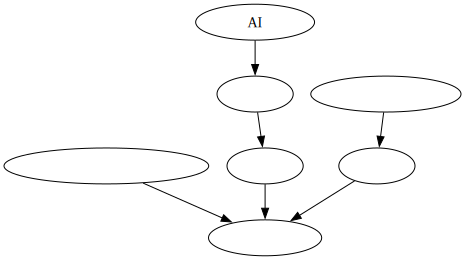

In [67]:
# これだと枝が重複するかも
# 固有IDあった方が良い
branchs = []
d = graphviz.Digraph()

# 「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」
for chunk in range(357,363):

    # 原文節をtail、係先文節をheadとして保持
    (tail, dst, _) = chunks[chunk].return_string_dependency()
    (head, _, _) = chunks[dst].return_string_dependency()

    # 枝として保存していく
    if dst > 0:
        d.edge(tail,head)

# 一文の係り受け木を表示
d

45. 動詞の格パターンの抽出

今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

- 動詞を含む文節において，最左の動詞の基本形を述語とする
- 述語に係る助詞を格とする
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．

```zsh
作り出す	で は を
```

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語と格パターンの組み合わせ
- 「行う」「なる」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）


In [68]:
# 書き込みモードで開く
f = open('verb_kaku.txt','w')

# 動詞に助詞がかかる場合のみ取り出す
for chunk in range(len(chunks)):

    # 文節が動詞を持つ場合のみ実行
    if chunks[chunk].has_verb:

        verb = None
        morphs = chunks[chunk].morphs

        for morph in morphs:

            # 各形態素の中から動詞のものを探して基本形を取り出す
            (_, base, pos, _) = morph.return_parsed()
            if pos == '動詞':
                verb = base
                break
        
        kakus = []
        (srcs, id) = chunks[chunk].return_string_sources()

        for srcs_index in srcs:

            if srcs_index < 0:
                continue

            kaku = ''
            morphs=chunks[srcs_index].morphs

            for morph in morphs:

                # 各形態素の中から助詞のものを探して基本形を取り出す
                (_, base, pos, _) = morph.return_parsed()
                if pos == '助詞':
                    kaku = base
            
            kakus.append(kaku)
        
        # print(verb+'\t',*kakus,sep=' ')
            
        # まず動詞を書き出しタブで区切り、格をスペースで区切って書き出す
        f.write(verb+'\t'+' '.join(sorted(kakus))+'\n')

f.close()

- コーパス中で頻出する述語と格パターンの組み合わせ

```zsh

% sort verb_kaku.txt | uniq -c | sort -n -r | head
  11 よる       に
   7 れる       と
   6 する       と
   5 用いる     を
   5 基づく     に
   4 行う       を
   4 ある       が
   3 関わる     も
   3 向ける     に
   3 受ける     を

```

- 「行う」「なる」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

```zsh

% grep "^行う\t" verb_kaku.txt | sort | uniq -c | sort -n -r | head
   4 行う       を
   1 行う       に を を
   1 行う       で に を
   1 行う        は を
   1 行う        で を

% grep "^なる\t" verb_kaku.txt | sort | uniq -c | sort -n -r | head
   2 なる       が と
   1 なる       が にとって は
   1 なる       と など
   1 なる       が て と
   1 なる       は を
   1 なる       に は
   1 なる       が に
   1 なる       に
   1 なる       と
   1 なる        が で と に は は

% grep "^与える\t" verb_kaku.txt | sort | uniq -c | sort -n -r | head
   1 与える     に は を
   1 与える     が に

```


46. 動詞の格フレーム情報の抽出

45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

- 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
- 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．

```zsh
作り出す	で は を	会議で ジョンマッカーシーは 用語を
```

In [69]:
f = open('verb_kaku_kou.txt','w')

# 45 に項を追加
for chunk in range(len(chunks)):

    # 文節が動詞を持つ場合のみ実行
    if chunks[chunk].has_verb:

        verb = None
        morphs = chunks[chunk].morphs

        for morph in morphs:

            # 各形態素の中から動詞のものを探して基本形を取り出す
            (_, base, pos, _) = morph.return_parsed()
            if pos == '動詞':
                verb = base
                break
        
        kakus, kous = [], []
        (srcs, id) = chunks[chunk].return_string_sources()

        for srcs_index in srcs:

            if srcs_index < 0:
                continue

            kaku, kou = '', ''
            morphs = chunks[srcs_index].morphs
            (mor, _, _) = chunks[srcs_index].return_string_dependency()
            
            for morph in morphs:

                # 各形態素の中から助詞のものを探して基本形を取り出す
                # 助詞だった場合はその文節ごと取り出す
                (_, base, pos, _) = morph.return_parsed()
                if pos == '助詞':
                    kaku = base
                    kou = mor

            # 助詞と文節を配列で格納
            kakus.append([kaku, kou])

        # 助詞に対してkakusをソートし、動詞、格、項の順にタブ区切りで書き出す
        kakus = sorted(kakus, key=lambda x: x[0])
        f.write(verb+'\t'+' '.join([x[0] for x in kakus])+'\t'+' '.join([x[1] for x in kakus])+'\n')

f.close()

- 出力結果における先頭10行

```txt
用いる	を	道具を
指す	を	一分野を
代わる	に を	人間に 知的行動を
せる	て に	代わって コンピューターに
れる	も	研究分野とも
いる	で に は	解説で 次のように 佐藤理史は
ある	 が は	 画像認識等が 応用例は
用いる	を	記号処理を
する	と を	主体と 記述を
いる	 でも は	 意味あいでも 現在では
```

47. 機能動詞構文のマイニング

動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

- 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
- 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
- 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）

例えば「また、自らの経験を元に学習を行う強化学習という手法もある。」という文から，以下の出力が得られるはずである．

```
学習を行う	に を	元に 経験を
```

In [70]:
f = open('sahen_wo_verb.txt','w')

# 動詞のヲ格にサ変接続名詞が入っている場合のみに着目
for chunk in range(len(chunks)):

    # # 文節が動詞を持つ場合のみ実行
    if chunks[chunk].has_verb:

        verb = None
        morphs = chunks[chunk].morphs

        for morph in morphs:

            # 各形態素の中から動詞のものを探して基本形を取り出す
            (_, base, pos, _) = morph.return_parsed()
            if pos == '動詞':
                verb = base
                break

        kakus, kous = [], []
        sahen_wo = ''
        sahen_wo_verb = None
        (srcs, id) = chunks[chunk].return_string_sources()

        for srcs_index in srcs:
            
            if srcs_index < 0:
                continue

            kaku, kou = '', ''
            morphs = chunks[srcs_index].morphs
            (mor, _, _) = chunks[srcs_index].return_string_dependency()

            if len(morphs) > 1 :

                # 形態素列が複数ある場合のみ
                if morphs[0].pos1 == 'サ変接続' and morphs[1].surface == 'を' and morphs[1].pos == '助詞':

                    # サ変接続名詞+を(助詞) のときのみ満たしているので、sahen_woに代入
                    sahen_wo = morphs[0].surface + morphs[1].surface

                    # 動詞も接続したsahen_wo_verbも別に作っておく
                    sahen_wo_verb = morphs[0].surface + morphs[1].surface + verb

            for morph in morphs:

                # 各形態素の中から助詞のものを探して基本形を取り出す
                # 助詞だった場合はその文節ごと取り出す
                (_, base, pos, _) = morph.return_parsed()
                if pos == '助詞':
                    kaku = base
                    kou = mor
            
            # 助詞と文節を配列で格納
            kakus.append([kaku, kou])

        for i in range(len(kakus)):

            # 「サ変接続名詞 + を」 の形であった場合は述語として表示されるためいらない
            if kakus[i][1] == sahen_wo:
                kakus.pop(i)
                break
        
        # 助詞に対してkakusをソート
        # 「サ変接続名詞+を+動詞の基本形」の場合のみ、述語、格、項の順にタブ区切りで書き出す
        kakus = sorted(kakus, key=lambda x: x[0])
        if sahen_wo_verb:
            f.write(sahen_wo_verb+'\t'+' '.join([x[0] for x in kakus])+'\t'+' '.join([x[1] for x in kakus])+'\n')
f.close()

- 出力結果

```txt
記述をする	と	主体と
注目を集める	   が	   サポートベクターマシンが
学習を行う	に を	元に 経験を
流行を超える		
学習を繰り返す		
進化を見せる	 て て において は	 活躍している 加えて 生成技術において 敵対的生成ネットワークは
開発を行う	 は	 エイダ・ラブレスは
処理を行う		
研究を進める	て	費やして
注目を集める	  から は	  ことから ファジィは
成功を受ける		
進歩を担う		
研究を続ける	が て	ジェフ・ホーキンスが 向けて
注目を集める	に	急速に
普及を受ける		
投資を行う	で に	民間企業主導で 全世界的に
探索を行う	 で	 無報酬で
研究を行う	 て	 始めており
実験をする		
投資をする	 に は	 2022年までに 韓国は
反乱を起こす	て に対して	於いて 人間に対して
弾圧を併せ持つ		
監視を行う	 に まで	 人工知能に 歩行者まで
差別を認める		
展開を変える		
判断を介す	から	観点から
禁止を求める	 が は	 ヒューマン・ライツ・ウォッチが 4月には
運用をめぐる		
試験を行う		
追及を受ける	 て で と とともに は	 暴露されており 整合性で 拒否すると とともに 公聴会では
話をする	 は	 哲学者は
議論を行う	  まで	  これまで
```

48. 名詞から根へのパスの抽出

文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ． ただし，構文木上のパスは以下の仕様を満たすものとする．

- 各文節は（表層形の）形態素列で表現する
- パスの開始文節から終了文節に至るまで，各文節の表現を” -> “で連結する

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．

```zsh
ジョンマッカーシーは -> 作り出した
AIに関する -> 最初の -> 会議で -> 作り出した
最初の -> 会議で -> 作り出した
会議で -> 作り出した
人工知能という -> 用語を -> 作り出した
用語を -> 作り出した
```

In [71]:
# 文節の端と端を決める
start, end = 357, 363

for chunk in range(start,end):

    dst, col = chunk, []

    # 係先が一文に収まる間は矢印で結合していく
    # これを一文のすべての文節に対して継続する
    while start <= dst and dst <= end:
        
        sur, dst, _ =  chunks[dst].return_string_dependency()
        col.append(sur)
    
    print(" -> ".join(col))

ジョンマッカーシーは -> 作り出した
AIに関する -> 最初の -> 会議で -> 作り出した
最初の -> 会議で -> 作り出した
会議で -> 作り出した
人工知能という -> 用語を -> 作り出した
用語を -> 作り出した


49. 名詞間の係り受けパスの抽出Permalink

文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号がi
とj（i < j）のとき，係り受けパスは以下の仕様を満たすものとする．

- 問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を” -> “で連結して表現する
- 文節iとjに含まれる名詞句はそれぞれ，XとYに置換する

また，係り受けパスの形状は，以下の2通りが考えられる．

- 文節iから構文木の根に至る経路上に文節jが存在する場合: 文節iから文節jのパスを表示
- 上記以外で，文節iと文節jから構文木の根に至る経路上で共通の文節kで交わる場合: 文節iから文節kに至る直前のパスと文節jから文節kに至る直前までのパス，文節kの内容を” | “で連結して表示

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．

```zsh
Xは | Yに関する -> 最初の -> 会議で | 作り出した
Xは | Yの -> 会議で | 作り出した
Xは | Yで | 作り出した
Xは | Yという -> 用語を | 作り出した
Xは | Yを | 作り出した
Xに関する -> Yの
Xに関する -> 最初の -> Yで
Xに関する -> 最初の -> 会議で | Yという -> 用語を | 作り出した
Xに関する -> 最初の -> 会議で | Yを | 作り出した
Xの -> Yで
Xの -> 会議で | Yという -> 用語を | 作り出した
Xの -> 会議で | Yを | 作り出した
Xで | Yという -> 用語を | 作り出した
Xで | Yを | 作り出した
Xという -> Yを
```

In [72]:
'''
- 文節iに含まれる名詞句はXに置換してnew_iとして返す
- 文節jに含まれる名詞句はXに置換してnew_jとして返す
- 二つのルートリストの重複を削除したものをrootsとして返す
'''
def return_path(root_i,root_j):

    new_i, new_j = [],[]

    # まず文節iのルートについて
    for i,clause in enumerate(root_i):

        bunnsetu = ''
        mor, _, id = clause[1].return_string_dependency()

        # 先頭の名刺を含む文節について
        if i == 0 :

            for morph in clause[1].morphs:

                # 形態素が名詞の場合はXに置換する
                # 名詞が複数ある場合はまとめてXとする
                if morph.pos == '名詞':

                    if 'X' in bunnsetu:
                        continue
                    bunnsetu += 'X'
                
                # それ以外はそのまま形態素を出力
                else:
                    bunnsetu += morph.surface
        
        # 名詞を含まなければ形態素列をそのまま文節として出力
        else:
            bunnsetu += mor

        # 置換したものを新たなルートとして追加
        new_i.append((id,bunnsetu))

    j_id = int()
    include_Y = tuple()

    # 文節jのルートについても同じように
    for j,clause in enumerate(root_j):

        bunnsetu = ''
        mor, _, id = clause[1].return_string_dependency()

        if j == 0 :

            for morph in clause[1].morphs:

                if morph.pos == '名詞':

                    if 'Y' in bunnsetu:
                        continue
                    bunnsetu += 'Y'
                    # Yを含む要素番号を保持しておく
                    j_id = id

                else:
                    bunnsetu += morph.surface
                
                # 文節とidを結んだタプルを保持しておく
                include_Y = (id,bunnsetu)

        else:
            bunnsetu += mor

        new_j.append((id,bunnsetu))
    
    for idx in range(len(new_i)):

        # ルートi,jに同じ文節を含む場合
        # ルートjの名詞句しかYに変わっていないので、ルートiも同じ箇所を変更
        if new_i[idx][0] == j_id:
            new_i[idx] = include_Y
            break

    # new_i,new_jのセット型を出力し、idについてソートする
    roots = sorted(set(new_i+new_j),key=lambda x:x[0])
    
    # 配列の要素はすべてタプルなので、配列に変更
    roots = [list(r) for r in roots]
    new_i = [list(i) for i in new_i]
    new_j = [list(j) for j in new_j]

    return roots, new_i, new_j

# 配列lについて要素xを発見した場合は要素番号を、未発見の場合はNoneを返す
def research_list(l,x):
    return l.index(x) if x in l else None


# 文節の端と端を決める
start, end = 357, 363

# 文節番号i
for i in range(start,end-1):

    # 文節番号j
    for j in range(i+1,end):
        
        chunks_i, chunks_j = chunks[i], chunks[j]

        # どちらも名詞を含んでいる場合のみ実行
        if chunks_i.has_noun and chunks_j.has_noun:

            root_i, root_j, dst_i, dst_j = [], [], i, j

            # それぞれの文節ついてルートを作成
            # idと文節を持つタプルをノードとしてリストルートを作成
            while start <= dst_i and dst_i <= end:
                mor_i = chunks[dst_i]
                _, dst_i, id_i =  chunks[dst_i].return_string_dependency()
                root_i.append((id_i,mor_i))
            while start <= dst_j and dst_j <= end:
                mor_j = chunks[dst_j]
                _, dst_j, id_j =  chunks[dst_j].return_string_dependency()
                root_j.append((id_j,mor_j))
        
            roots, new_i, new_j  = return_path(root_i,root_j)

            for root in roots:

                # rootsに入っている要素をnew_i,new_jについて探索
                idx = research_list(new_i,root)
                jdx = research_list(new_j,root)

                # どちらも要素番号が得られない場合
                # 交差点がないので矢印パスを文節ノードの要素として追加
                # 出力ノード側に追加する
                if idx == None:
                    new_j[jdx].append(' -> ')
                elif jdx == None:
                    new_i[idx].append(' -> ')
                
                # 両方要素番号が得られた場合
                else:

                    # iの途中に名詞文節jを含む場合はそれ以降を切り捨て
                    # それぞれ結合して終了
                    if 'Y' in root[1]:
                        tail = new_i[:idx]+new_j[:jdx+1]
                        break

                    # ルートiの文節ノードがパスを含む場合
                    if len(new_i[idx-1]) > 2:
                        # すでに登録されているパスを' | 'に更新する
                        new_i[idx-1][2] = ' | '
                    
                    # ルートiの文節ノードがパスを含まない場合
                    else:
                        # 追加する
                        new_i[idx-1].append(' | ')

                    # ルートjについても行う
                    if len(new_j[jdx-1]) > 2:
                        new_j[jdx-1][2] = ' | '

                    else:
                        new_j[jdx-1].append(' | ')
                
                # 結合箇所は文節が2回出てくるのでnew_i側は削除
                tail = new_i[:-1]+new_j
            
            # 結合箇所はパスを含まないので空白を追加
            tail[-1].append('')
            col = ''

            for t in sorted(tail):

                # new_i,new_j両ルートについてidでソート
                # 文節とパスをすべて足し合わせる
                col += t[1]+t[2]
            
            print(col)

Xは | Yに関する -> 最初の -> 会議で | 作り出した
Xは | Yの -> 会議で | 作り出した
Xは | Yで | 作り出した
Xは | Yという -> 用語を | 作り出した
Xは | Yを | 作り出した
Xに関する -> Yの
Xに関する -> 最初の -> Yで
Xに関する -> 最初の -> 会議で | Yという -> 用語を | 作り出した
Xに関する -> 最初の -> 会議で | Yを | 作り出した
Xの -> Yで
Xの -> 会議で | Yという -> 用語を | 作り出した
Xの -> 会議で | Yを | 作り出した
Xで | Yという -> 用語を | 作り出した
Xで | Yを | 作り出した
Xという -> Yを
